## This is HNA or Hybrid SFLA-CSO Network Aligner program, and implemented by Elham Mahdipour that is Ph.D. Candidate of Artificial Intelligence at Yazd University, Yazd, Iran. 
### All copyright reserved by the author.

You can run the program from first to end and see all the results, but since the population generation process can take a time depended on the node numbers of networks, you can use the populations stored in each program. We saved the populations as the pair of related species that you can see in the input folder and load them on program, such as "ce-sc-pop.pickle". Therefore, you must run follow steps: 1) Run all cells in "Load Graphs", "Swap Graphs", "Define Target Graph",and "Compute Score for create similarity matrix" sections. 2) If you will use saved population, please upload related pickle on root of jupyter notebook, then go "load population" cell and run them; else, please run "multi tasking for initial population", "multi processing for speed up", and "Initialization such as MeAlign" cells. 3) Run all remains cells to create results.

# load Graphs 

In [1]:
import pickle
with open('sc-sc-weighted.pickle', 'rb') as f:
    sclist = pickle.load(f)

In [2]:
with open('hs-hs-weighted.pickle', 'rb') as f:
    hslist = pickle.load(f)

In [3]:
import networkx as nx
G1=nx.Graph()
for i in range(len(sclist)):
    if G1.has_node(sclist[i][0])==False:
        G1.add_node(sclist[i][0])
    if G1.has_node(sclist[i][1])==False:
        G1.add_node(sclist[i][1])
    G1.add_edge(sclist[i][0],sclist[i][1],weight=sclist[i][2])
G1

In [4]:
G2=nx.Graph()
for i in range(len(hslist)):
    if G2.has_node(hslist[i][0])==False:
        G2.add_node(hslist[i][0])
    if G2.has_node(hslist[i][1])==False:
        G2.add_node(hslist[i][1])
    G2.add_edge(hslist[i][0],hslist[i][1],weight=hslist[i][2])
G2

In [5]:
print('mm: len G1:', len(G1))

print('hs: len G2:',len(G2))

mm: len G1: 5513
hs: len G2: 10399


# Swap graphs if len G1 > len G2

In [6]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

5513
10399


In [7]:
ed1=G1.edges()

In [8]:
nd1=G1.nodes()

In [9]:
ed2=G2.edges()

In [10]:
len(ed2)

142847

In [11]:
nd2=G2.nodes()

In [12]:
len(ed1)

16185

In [13]:
len(nd1)

5513

In [14]:
el1=list(ed1)
el2=list(ed2)

In [15]:
nd1=list(nd1)
nd2=list(nd2)

In [16]:
degG1 = [val for (node, val) in G1.degree()]


In [17]:
degG2 = [val for (node, val) in G2.degree()]

# Define Target Graph

In [18]:
G_target_na=nx.read_weighted_edgelist('hs-sc.evals')
G_target_na  

In [19]:
gtnode=list(G_target_na.nodes())
print(len(gtnode))
g_t_node=[]
for i in range(len(gtnode)):
    if (G1.has_node(gtnode[i])==False and G2.has_node(gtnode[i])==False):
        continue
    else:
        g_t_node.append(gtnode[i])

#print(gtnode)
print(len(g_t_node))

12176
8412


In [20]:
G_target=nx.Graph()
for i in range(len(g_t_node)):
    for j in range(len(g_t_node)):
        if G_target_na.has_node(g_t_node[i])==False:
            G_target.add_node(g_t_node[i])
        if G_target_na.has_node(g_t_node[j])==False:
            G_target.add_node(g_t_node[j])
        if G_target_na.has_edge(g_t_node[i],g_t_node[j]):
            a=list(G_target_na.get_edge_data(g_t_node[i],g_t_node[j]).values())            
            G_target.add_edge(g_t_node[i],g_t_node[j],weight=a[0])
G_target

In [21]:
len(G_target)

7979

In [22]:
G_target_na=G_target

# Compute Score for create similarity matrix 

In [23]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [24]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [25]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [26]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node
    

In [27]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [28]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [29]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [30]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s

In [31]:
import numpy as np
m=compute_score(G1,G2)
n=m


# multi tasking for initial population

In [32]:
def task1(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task1')
    for z1 in range(int(len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
  

In [33]:
def task2(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task2')
    for z1 in range(int(len_G1/3),int(2*len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

In [34]:
def task3(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task3')
    for z1 in range(int(2*len_G1/3),len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

# multi processing for speed up

In [35]:
def fun_rand_permute(len_G1, base_permute, rand_permutation):
    for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)
    #print(rand_permutation)

# Initial other method

In [32]:
#import threading
import random

len_G1=len(G1)
len_G2=len(G2)
simmat=m
len_pop=300
npop=np.zeros((len_pop,len_G1,2))
#rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]
print('wait')
"""t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
t.start() 
t.join()
#print(rand_permutation)
    

    print('for loop')
    if i>0:
        do_not_permute = set(base_permute)-set(ind)#[item for item in base_permute if item not in index_score]
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
     """
    
for i in range(len_pop): 
    ind=np.argmax(simmat,axis=1)
    for j in range(len_G1):
        npop[i][j][0]=nd1.index(nd1[j])
        #if (ind[j]<len_G1):
         #   npop[i][j][1]=nd2.index(nd2[int(rand_permutation[j][ind[j]])])
        #else:
        npop[i][j][1]=nd2.index(nd2[ind[j]])
        simmat[j,ind[j]]=0
    print('Done i=',i)
npop

wait
Done i= 0
Done i= 1
Done i= 2
Done i= 3
Done i= 4
Done i= 5
Done i= 6
Done i= 7
Done i= 8
Done i= 9
Done i= 10
Done i= 11
Done i= 12
Done i= 13
Done i= 14
Done i= 15
Done i= 16
Done i= 17
Done i= 18
Done i= 19
Done i= 20
Done i= 21
Done i= 22
Done i= 23
Done i= 24
Done i= 25
Done i= 26
Done i= 27
Done i= 28
Done i= 29
Done i= 30
Done i= 31
Done i= 32
Done i= 33
Done i= 34
Done i= 35
Done i= 36
Done i= 37
Done i= 38
Done i= 39
Done i= 40
Done i= 41
Done i= 42
Done i= 43
Done i= 44
Done i= 45
Done i= 46
Done i= 47
Done i= 48
Done i= 49
Done i= 50
Done i= 51
Done i= 52
Done i= 53
Done i= 54
Done i= 55
Done i= 56
Done i= 57
Done i= 58
Done i= 59
Done i= 60
Done i= 61
Done i= 62
Done i= 63
Done i= 64
Done i= 65
Done i= 66
Done i= 67
Done i= 68
Done i= 69
Done i= 70
Done i= 71
Done i= 72
Done i= 73
Done i= 74
Done i= 75
Done i= 76
Done i= 77
Done i= 78
Done i= 79
Done i= 80
Done i= 81
Done i= 82
Done i= 83
Done i= 84
Done i= 85
Done i= 86
Done i= 87
Done i= 88
Done i= 89
Done i= 90
Done

array([[[0.000e+00, 8.000e+00],
        [1.000e+00, 7.007e+03],
        [2.000e+00, 7.007e+03],
        ...,
        [5.510e+03, 8.048e+03],
        [5.511e+03, 8.000e+00],
        [5.512e+03, 8.000e+00]],

       [[0.000e+00, 1.800e+01],
        [1.000e+00, 7.006e+03],
        [2.000e+00, 7.006e+03],
        ...,
        [5.510e+03, 8.000e+00],
        [5.511e+03, 1.800e+01],
        [5.512e+03, 1.800e+01]],

       [[0.000e+00, 1.900e+01],
        [1.000e+00, 4.437e+03],
        [2.000e+00, 4.437e+03],
        ...,
        [5.510e+03, 1.800e+01],
        [5.511e+03, 1.900e+01],
        [5.512e+03, 1.900e+01]],

       ...,

       [[0.000e+00, 5.900e+03],
        [1.000e+00, 8.658e+03],
        [2.000e+00, 8.658e+03],
        ...,
        [5.510e+03, 5.892e+03],
        [5.511e+03, 5.900e+03],
        [5.512e+03, 5.900e+03]],

       [[0.000e+00, 5.904e+03],
        [1.000e+00, 3.260e+03],
        [2.000e+00, 3.260e+03],
        ...,
        [5.510e+03, 5.900e+03],
        [5.511e+03

In [33]:
pop=npop

# Initialization such as MeAlign

In [ ]:
#%%prun
import random
import threading

len_pop=300 
len_G1=len(G1)
len_G2=len(G2)
similarity_score_matrix=np.zeros((len_G1,len_G1))
sim_score_matrix=np.zeros((len_G1,len_G1))
pop=np.zeros((len_pop,len_G1,2))
index_score=np.zeros(len_G1)
rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]

for i in range(len_pop):  
    print('wait')
    if i>0:
        do_not_permute = set(base_permute)-set(index_score)#[item for item in base_permute if item not in index_score]
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
     
    t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
    t.start() 
    t.join()
    #print(rand_permutation)
    
    """for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)                
    print('in for loop')
    for z1 in range(len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])"""
     
    
    t1 = threading.Thread(target=task1, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,)) 
    t2 = threading.Thread(target=task2, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    t3 = threading.Thread(target=task3, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    # starting thread 1 
    t1.start() 
    # starting thread 2 
    t2.start() 
    # starting thread 3 
    t3.start() 
    # wait until thread 1 is completely executed 
    t1.join() 
    # wait until thread 2 is completely executed 
    t2.join() 
    # wait until thread 3 is completely executed 
    t3.join()
    # both threads completely executed 
    print("Done!, i=",i) 
    
pop

wait
task1task2

task3
Done!, i= 0
wait
task1
task2
task3
Done!, i= 1
wait
task1
task2
task3
Done!, i= 2
wait
task1
task2
task3
Done!, i= 3
wait
task1
task2
task3
Done!, i= 4
wait
task1
task2
task3
Done!, i= 5
wait
task1task2

task3
Done!, i= 6
wait
task1
task2
task3
Done!, i= 7
wait
task1
task2task3

Done!, i= 8
wait
task1task2

task3
Done!, i= 9
wait
task1
task2
task3
Done!, i= 10
wait
task1
task2
task3
Done!, i= 11
wait
task1
task2
task3
Done!, i= 12
wait
task1
task2
task3
Done!, i= 13
wait
task1
task2
task3
Done!, i= 14
wait
task1
task2
task3
Done!, i= 15
wait
task1
task2
task3
Done!, i= 16
wait
task1
task2
task3
Done!, i= 17
wait
task1
task2
task3
Done!, i= 18
wait
task1
task2
task3
Done!, i= 19
wait
task1
task2task3

Done!, i= 20
wait
task1
task2
task3


# save population

In [42]:
import pickle
with open('sc-hs-base_permute.pickle', 'wb') as f:
    pickle.dump(base_permute, f)

In [43]:
import pickle
with open('sc-hs-pop.pickle', 'wb') as f:
    pickle.dump(pop, f)

## You can load population if there is save population such as 'sc-hs-pop.pickle'

# load population

In [ ]:
with open('sc-hs-base_permute', 'rb') as f:
    base_permute = pickle.load(f)

In [ ]:
with open('sc-hs-pop.pickle', 'rb') as f:
    pop = pickle.load(f)

# compute measure edge correctness, ics, nc and s3

In [34]:
def induced_function_for_initialpop(sub_pop):
    num_induced=0
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    for i in range(len(sub_g2)):
        for j in range(i,len(sub_g2)):
            if G2.has_edge(nd2[int(sub_g2[i])], nd2[int(sub_g2[j])]):
                num_induced=num_induced+1
    return num_induced

In [35]:
score_ec=np.zeros(len_pop)
score_ics=np.zeros(len_pop)
score_s3=np.zeros(len_pop)
score_nc=np.zeros(len_pop)
num_seq=np.zeros(len_pop)
score_ncorectness=np.zeros(len_pop)

p=pop 
len_G1=len(G1)
map_items=[] #np.zeros((len_pop,len_G1,2))

for i in range(len(p)):
    ec=0
    nc=0
    sub_pop=p[i]
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    num_induced=induced_function_for_initialpop(sub_pop) 
    #print("number induced for i=",i," is: ",num_induced)
    
    for j in range(len_G1):                            
         if G_target_na.has_edge(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]):
            num_seq[i]+=1  # create sequence matrix 
            map_items.append([nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]])
            ec=ec+1            
            nc=nc+2
                 
    score_ec[i]=ec/G1.number_of_edges()*100
    score_ics[i]=ec/num_induced*100
    score_s3[i]=ec/(G1.number_of_edges()+num_induced-ec)*100
    score_nc[i]=nc/G1.number_of_nodes()*100 
    score_ncorectness[i]=(nc/G_target_na.number_of_nodes())*100
    print('done i=',i)
    """if (score_nc[i] > 100):
        score_nc[i]=100
    if (score_ec[i] > 100):
        score_ec[i]=100
    if (score_ics[i] > 100):
        score_ics[i]=100
    if (score_s3[i] > 100):
        score_s3[i]=100
    if ( score_ncorectness[i]>100):
         score_ncorectness[i]=100"""

print('ec')
print(score_ec)
print('ics')
print(score_ics)
print('s3')
print(score_s3)
print('nc',score_nc)
print('node correctness: ',  score_ncorectness)

done i= 0
done i= 1
done i= 2
done i= 3
done i= 4
done i= 5
done i= 6
done i= 7
done i= 8
done i= 9
done i= 10
done i= 11
done i= 12
done i= 13
done i= 14
done i= 15
done i= 16
done i= 17
done i= 18
done i= 19
done i= 20
done i= 21
done i= 22
done i= 23
done i= 24
done i= 25
done i= 26
done i= 27
done i= 28
done i= 29
done i= 30
done i= 31
done i= 32
done i= 33
done i= 34
done i= 35
done i= 36
done i= 37
done i= 38
done i= 39
done i= 40
done i= 41
done i= 42
done i= 43
done i= 44
done i= 45
done i= 46
done i= 47
done i= 48
done i= 49
done i= 50
done i= 51
done i= 52
done i= 53
done i= 54
done i= 55
done i= 56
done i= 57
done i= 58
done i= 59
done i= 60
done i= 61
done i= 62
done i= 63
done i= 64
done i= 65
done i= 66
done i= 67
done i= 68
done i= 69
done i= 70
done i= 71
done i= 72
done i= 73
done i= 74
done i= 75
done i= 76
done i= 77
done i= 78
done i= 79
done i= 80
done i= 81
done i= 82
done i= 83
done i= 84
done i= 85
done i= 86
done i= 87
done i= 88
done i= 89
done i= 90
done i= 9

## number of matched sequences 

In [36]:
num_seq

array([2939., 1905., 1474., 1240., 1051.,  956.,  889.,  822.,  773.,
        734.,  693.,  635.,  586.,  563.,  541.,  523.,  505.,  482.,
        468.,  442.,  425.,  415.,  402.,  392.,  378.,  363.,  343.,
        333.,  316.,  306.,  292.,  282.,  275.,  271.,  267.,  263.,
        256.,  253.,  249.,  246.,  242.,  241.,  240.,  239.,  237.,
        236.,  232.,  232.,  228.,  228.,  226.,  224.,  224.,  221.,
        217.,  216.,  215.,  212.,  211.,  206.,  204.,  203.,  199.,
        197.,  196.,  194.,  193.,  192.,  188.,  187.,  186.,  185.,
        181.,  179.,  178.,  176.,  172.,  169.,  165.,  164.,  161.,
        158.,  155.,  151.,  148.,  147.,  145.,  143.,  142.,  142.,
        138.,  137.,  135.,  133.,  131.,  128.,  126.,  125.,  125.,
        123.,  122.,  121.,  118.,  117.,  116.,  114.,  114.,  112.,
        112.,  112.,  112.,  111.,  111.,  111.,  111.,  110.,  110.,
        107.,  104.,  104.,  103.,  103.,  100.,   99.,   98.,   96.,
         96.,   92.,

## compute topology score

In [37]:
#compute Final Score
tscore=np.zeros(len_pop)
for i in range(len(p)):
    tscore[i]=(0.25*(score_ec[i]/G1.number_of_edges())+0.25*(score_s3[i]/(G1.number_of_edges()+score_ics[i]-score_ec[i]))+0.25*(score_ics[i]/2*G1.number_of_edges())+0.25*(score_nc[i]/(G1.number_of_nodes()+G2.number_of_nodes())))
print(tscore)

[75667.65774444 52744.6726095  49071.68530943 37918.30502513
 33089.08224052 31800.51862712 27980.05860433 28826.63867254
 27212.03511052 24288.08935352 23374.88588938 21497.39630142
 19895.13803888 18288.68658975 18955.84773186 18979.27168648
 17287.27829093 17021.23006396 15192.91594126 18204.8303353
 15378.78988607 14288.57884558 14468.88928422 14131.59330409
 14270.22326847 14128.40301927 13508.50473081 12147.50520414
 11221.82751041 10637.04919447 10887.44031866  9874.02668748
  9850.55570906 10491.13825983 10172.77562082  9947.31511277
 10058.65235457  9291.17145178  9795.02497491 10183.93204197
  9232.43936399  9274.74099968  9269.75962737  8765.89711242
  9759.42669672 10173.82288937  9083.89798438  8957.34749953
  8194.57291629  8562.69740229  8586.40861749  9607.37773627
  8936.69904146  9324.5178903   8455.66512556  8473.82214905
  9188.25269396  8377.00210971  8094.03456985  8422.87303021
  8192.09026586  7876.76223272  8229.80135319  8336.23994912
  8451.24694813  7713.959

# Compute Topology and Sequence score

In [38]:
# Final Score
score=np.zeros(len_pop)
alpha=0.5
for i in range (len(p)):
    score[i]=alpha*tscore[i]+(1-alpha)*num_seq[i]   
score

array([39303.32887222, 27324.83630475, 25272.84265471, 19579.15251257,
       17070.04112026, 16378.25931356, 14434.52930216, 14824.31933627,
       13992.51755526, 12511.04467676, 12033.94294469, 11066.19815071,
       10240.56901944,  9425.84329488,  9748.42386593,  9751.13584324,
        8896.13914547,  8751.61503198,  7830.45797063,  9323.41516765,
        7901.89494303,  7351.78942279,  7435.44464211,  7261.79665204,
        7324.11163423,  7245.70150964,  6925.7523654 ,  6240.25260207,
        5768.91375521,  5471.52459723,  5589.72015933,  5078.01334374,
        5062.77785453,  5381.06912991,  5219.88781041,  5105.15755639,
        5157.32617729,  4772.08572589,  5022.01248745,  5214.96602099,
        4737.21968199,  4757.87049984,  4754.87981368,  4502.44855621,
        4998.21334836,  5204.91144469,  4657.94899219,  4594.67374976,
        4211.28645815,  4395.34870115,  4406.20430874,  4915.68886814,
        4580.34952073,  4772.75894515,  4336.33256278,  4344.91107452,
      

## Define function for fitness and compute final score

In [39]:
def induced_function_for_pop(wpop):
    counter_induced=0
    subg=list(set([wpop[i][1] for i in range(len_G1)]))
    for i in range(len(subg)):
        for j in range(i,len(subg)):
            if G2.has_edge(nd2[int(subg[i])], nd2[int(subg[j])]):
                counter_induced=counter_induced+1
    #print("con: ",counter_induced)
    return counter_induced

In [40]:
def Fitness(wpop, counter_induced):
    ec_temp=0
    nc_temp=0
    num_seq_temp=0
    score_ncorectness=0
    
    for j in range(len_G1):        
        x1=int(wpop[j][0])
        x2=int(wpop[j][1])
        if G_target_na.has_edge(nd1[x1],nd2[x2]):
            num_seq_temp+=1              
            ec_temp=ec_temp+1            
            nc_temp=nc_temp+2
                 
    score_ec_temp=ec_temp/G1.number_of_edges()*100
    score_ics_temp=ec_temp/counter_induced*100
    score_s3_temp=ec_temp/(G1.number_of_edges()+counter_induced-ec_temp)*100
    score_nc_temp=nc_temp/G1.number_of_nodes()*100
    score_ncorectness=(nc_temp/G_target_na.number_of_nodes())*100
    """if (score_nc_temp > 100):
        score_nc_temp=100
    if (score_ec_temp > 100):
        score_ec_temp=100
    if (score_ics_temp > 100):
        score_ics_temp=100
    if (score_s3_temp > 100):
        score_s3_temp=100
    if ( score_ncorectness>100):
         score_ncorectness=100"""
    # local measures
    pre=ec_temp/G_target_na.number_of_edges()*100
    rec=ec_temp/len(wpop)*100
    fsc=(2*(pre*rec)/(pre+rec))
    
    if (GbestFlag==True):
        print('ec')
        print(score_ec_temp)
        print('ics')
        print(score_ics_temp)
        print('s3')
        print(score_s3_temp)
        print('nc',score_nc_temp)
        print('node correctness:',score_ncorectness)
        print('num_seq',num_seq_temp)
        print('precision: ',pre)
        print('Recall: ',rec)
        print('F-score: ',fsc)

    alpha=0.5
    tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
    score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
    print('score:',score_temp)
    
    return score_temp,pre,rec,fsc

# HNA: Hybrid SFLA-CSO proposed method

In [42]:
# Implementation of Hybrid SFLA-CSO Algorithm
import random
from operator import itemgetter
from random import shuffle
import concurrent.futures

precision=np.zeros(len_pop)
recall=np.zeros(len_pop)
fscore=np.zeros(len_pop)


dim=len_G1
new_pop=p.tolist()
[new_pop[i].append(score[i]) for i in range(len_pop)]
#[print(new_pop[i][dim]) for i in range(len_pop)]

new_pop=sorted(new_pop, key=itemgetter(dim),reverse=True)
counter_induced=num_induced #0

GBestFrog=new_pop[0]
#print("GBest: ",GBestFrog)

index=0
iteration=2
epoch=0
memeplex=100
GbestFlag=False

group=int(len_pop/memeplex)
len_G1=len(G1)
dim=len_G1

max_score=max(score)
while (epoch<1):
    k=u=0
    #==== Set memeplexes =====
    memp=[]
    memp.append([new_pop[0],new_pop[memeplex],new_pop[2*memeplex]]) #,pop[3*memeplex],pop[4*memeplex]])
    for i in range(1,memeplex):    
        memp.append([new_pop[i],new_pop[i+memeplex],new_pop[i+2*memeplex]]) #,pop[i+3*memeplex],pop[i+4*memeplex]])
    #print('Check memeplex')
    #[[print(memp[i][j][dim]) for j in range(group)]for i in range(memeplex)]
    #=== Local Search =====   
    while(k<memeplex):
        u=0
        print("k ",k)
        print("epoch ",epoch)
        while(u<iteration):
            print("u ",u)
            memp[k]=sorted(memp[k], key=itemgetter(dim),reverse=True)
            #print('Check sort memeplex')
            #[[print(memp[i][j][dim]) for j in range(group)]for i in range(memeplex)]
            #=== set best frog and worst frog 
            bestFrog=memp[k][0]
            worstFrog=memp[k][group-1]            
            #print("BestFrog",bestFrog[dim])
            #print("WorstFrog",worstFrog[dim])
            r1=random.random()
            c1=2
            TeV=(worstFrog[dim]+r1*c1*(bestFrog[dim]-worstFrog[dim]))/100             #number of permutation
           # print(TeV)
                       
            # move 1
            temp_worst=worstFrog    #temp_worst is TeX
            
            Flag_move1=False
            
            # counter induced for ics compute            
            """with concurrent.futures.ThreadPoolExecutor() as executor:
                future = executor.submit(induced_function_for_pop, temp_worst)
                counter_induced = future.result()
                #print("counter induced: ",counter_induced)"""
            
            for i in range(int(TeV)):
                rand_index1=random.randint(0,dim-1)
                rand_permute=random.sample(base_permute,len_G1)                
                #print('rand1',rand_index1)                                
                if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                                                 
                        temp_score=np.argmax(m[rand_index1])
                        #print(nd2[temp_score])                        
                        #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                        if(G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score])):                                
                                temp_worst[rand_index1][1]=temp_score
                                Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                                if(Fit_New>worstFrog[dim]):
                                    print('w',worstFrog[dim])
                                    print('new',Fit_New)
                                    temp_worst[dim]=Fit_New
                                    memp[k][group-1]=temp_worst 
                                    Flag_move1=True
                                    print('move1 ', TeV)                                                                 
            #======== move 2 =======
            Flag_move2=False
            
            if(Flag_move1==False):
                    TeV=(worstFrog[dim]+r1*c1*(GBestFrog[dim]-worstFrog[dim]))/100   #number of random permutation                
                            #print(TeV)                
           
                    temp_worst=worstFrog    #temp_worst is TeX               
                
                    for i in range(int(TeV)):
                        rand_permute=random.sample(base_permute,len_G1)
                        rand_index1=random.randint(0,dim-1)
                        if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                            
                            temp_score=np.argmax(m[rand_index1])
                            #print(nd2[temp_score])
                            #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                            if(G_target_na.has_edge(temp_worst[rand_index1][0],nd2[temp_score])):                                
                                temp_worst[rand_index1][1]=temp_score                                                                   
                                Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                                if(Fit_New>worstFrog[dim]):
                                    print('w',worstFrog[dim])
                                    print('new',Fit_New)
                                    temp_worst[dim]=Fit_New
                                    memp[k][group-1]=temp_worst 
                                    Flag_move2=True
                                    print('move2 ', TeV)                                                                      
                    #===== move 3 =====
            
            if(Flag_move1==False and Flag_move2==False):
                TeV=(worstFrog[dim]*random.random()*2)/100             #number of permutation
                                            # print(TeV)
                              
                temp_worst=worstFrog   #temp_worst is TeX                    
                for i in range(int(TeV)):
                    rand_permute=random.sample(base_permute,len_G1)
                    rand_index1=random.randint(0,dim-1) 
                    if not(G_target_na.has_edge(temp_worst[rand_index1][0],temp_worst[rand_index1][1])):                        
                        temp_score=np.argmax(m[rand_index1])
                        #print(nd2[temp_score])
                        #print('temp:',G_target_na.has_edge(nd1[int(temp_worst[rand_index1][0])],nd2[temp_score]))
                        if (G_target_na.has_edge(temp_worst[rand_index1][0],nd2[temp_score])):                                                    
                            temp_worst[rand_index1][1]=temp_score                            
                            Fit_New,pre,rec,fsc=Fitness(temp_worst,counter_induced)     
                            if(Fit_New>worstFrog[dim]):
                                print('w',worstFrog[dim])
                                print('new',Fit_New)
                                temp_worst[dim]=Fit_New
                                memp[k][group-1]=temp_worst  
                                print('move3 ',TeV)
                
            u=u+1
        k=k+1    
    epoch+=1
    #==== combine memeplexes and create new pop ====
    print('*********** fitness **************')    
    new_pop=[]
    for i in range(memeplex):
        for j in range(group):        
            del memp[i][j][dim]
       
    [[new_pop.append(memp[i][j]) for j in range(group)] for i in range(memeplex)]         
    
    for i in range(len_pop):
        Fit,pre,rec,fsc=Fitness(new_pop[i],counter_induced)
        print('Fit pop',Fit)
        new_pop[i].append(Fit)
        score[i]=Fit
        precision[i]=pre
        recall[i]=rec
        fscore[i]=fsc
    
    
    new_pop=sorted(new_pop, key=itemgetter(dim), reverse=True)
    print('********** new population ************')
    [print('Fitness: ',new_pop[i][dim]) for i in range(len_pop)]
    
    GBestFrog=new_pop[0]
    
print("GBest: ",GBestFrog)    
print("epoch: ",epoch)
print("score:", score)
#********** print Local Measures *********
print("Precision: ",precision)
print("Recall: ", recall)
print("F-measure: ",fscore)
#******** map items **********
map_items=[]
weight=[]
for i in range(len_pop):
    for j in range(len_G1):
        if G_target_na.has_edge(nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])]):
            map_items.append([nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])]]) 
            weight.append(G_target_na.get_edge_data(nd1[int(new_pop[i][j][0])],nd2[int(new_pop[i][j][1])])) 

print("end")

k  0
epoch  0
u  0
u  1
k  1
epoch  0
u  0
score: 1025.923911849882
u  1
k  2
epoch  0
u  0
u  1
k  3
epoch  0
u  0
score: 916.0034927229532
u  1
k  4
epoch  0
u  0
u  1
score: 952.6436324319252
score: 952.6436324319252
k  5
epoch  0
u  0
u  1
k  6
epoch  0
u  0
u  1
k  7
epoch  0
u  0
u  1
k  8
epoch  0
u  0
u  1
k  9
epoch  0
u  0
u  1
k  10
epoch  0
u  0
u  1
k  11
epoch  0
u  0
u  1
k  12
epoch  0
u  0
u  1
k  13
epoch  0
u  0
u  1
k  14
epoch  0
u  0
u  1
k  15
epoch  0
u  0
u  1
k  16
epoch  0
u  0
u  1
k  17
epoch  0
u  0
u  1
k  18
epoch  0
u  0
u  1
k  19
epoch  0
u  0
u  1
k  20
epoch  0
u  0
u  1
k  21
epoch  0
u  0
u  1
k  22
epoch  0
u  0
u  1
k  23
epoch  0
u  0
u  1
k  24
epoch  0
u  0
score: 696.162654469208
u  1
k  25
epoch  0
u  0
u  1
k  26
epoch  0
u  0
u  1
k  27
epoch  0
u  0
u  1
k  28
epoch  0
u  0
u  1
k  29
epoch  0
u  0
u  1
k  30
epoch  0
u  0
u  1
k  31
epoch  0
u  0
u  1
k  32
epoch  0
u  0
u  1
k  33
epoch  0
u  0
u  1
k  34
epoch  0
u  0
u  1
k  35
epoch

score: 3370.8928532332984
Fit pop 3370.8928532332984
score: 622.8823750513262
Fit pop 622.8823750513262
score: 9636.356743576951
Fit pop 9636.356743576951
score: 2638.0900590491415
Fit pop 2638.0900590491415
score: 586.2422353423914
Fit pop 586.2422353423914
score: 10332.519398067307
Fit pop 10332.519398067307
score: 2381.609081085083
Fit pop 2381.609081085083
score: 586.2422353423914
Fit pop 586.2422353423914
score: 10076.038420096993
Fit pop 10076.038420096993
score: 2528.1696399216626
Fit pop 2528.1696399216626
score: 586.2422353423914
Fit pop 586.2422353423914
score: 9123.394787637688
Fit pop 9123.394787637688
score: 2381.609081085083
Fit pop 2381.609081085083
score: 586.2422353423914
Fit pop 586.2422353423914
score: 8683.713111118992
Fit pop 8683.713111118992
score: 2381.609081085083
Fit pop 2381.609081085083
score: 586.2422353423914
Fit pop 586.2422353423914
score: 8207.391294891102
Fit pop 8207.391294891102
score: 2235.04852224857
Fit pop 2235.04852224857
score: 586.242235342391

score: 1245.7647501038514
Fit pop 1245.7647501038514
score: 219.84083825327252
Fit pop 219.84083825327252
score: 5312.820257829449
Fit pop 5312.820257829449
score: 1245.7647501038514
Fit pop 1245.7647501038514
score: 219.84083825327252
Fit pop 219.84083825327252
score: 4433.45690480331
Fit pop 4433.45690480331
score: 1209.1246103948463
Fit pop 1209.1246103948463
score: 219.84083825327252
Fit pop 219.84083825327252
score: 5202.899838701049
Fit pop 5202.899838701049
score: 1245.7647501038514
Fit pop 1245.7647501038514
score: 183.20069854438347
Fit pop 183.20069854438347
score: 4506.737184222062
Fit pop 4506.737184222062
score: 1172.4844706858446
Fit pop 1172.4844706858446
score: 183.20069854438347
Fit pop 183.20069854438347
score: 4946.418860734928
Fit pop 4946.418860734928
score: 1172.4844706858446
Fit pop 1172.4844706858446
score: 183.20069854438347
Fit pop 183.20069854438347
score: 4470.097044512685
Fit pop 4470.097044512685
score: 1172.4844706858446
Fit pop 1172.4844706858446
score: 

end


In [43]:
# GbestFrog
gb=new_pop[0]
del gb[dim]
GbestFlag=True
fit_gb,pre,rec,fsc=Fitness(gb,counter_induced)
print('gbest fitness ', fit_gb)

ec
18.158789002162496
ics
105.00178635226867
s3
18.317232782798378
nc 106.62071467440595
node correctness: 73.66837949617747
num_seq 2939
precision:  6.7108117364996005
Recall:  53.31035733720297
F-score:  11.920986452502635
score: 107685.37062550442
gbest fitness  107685.37062550442


In [44]:
counter_induced

2799

## Remove duplication and local alignment
## Compute Global Alignment

In [45]:
x=[[map_items[i][0],map_items[i][1],int(list(weight[i].values())[0])] for i in range(len(map_items))]
x

[['sc434', 'hs8879', 105],
 ['sc3383', 'hs8879', 79],
 ['sc1023', 'hs2332', 115],
 ['sc6481', 'hs21911', 73],
 ['sc2258', 'hs9081', 103],
 ['sc898', 'hs3481', 347],
 ['sc2639', 'hs11624', 150],
 ['sc2281', 'hs9081', 72],
 ['sc5593', 'hs19656', 91],
 ['sc5387', 'hs19656', 88],
 ['sc3630', 'hs13143', 62],
 ['sc4560', 'hs16381', 124],
 ['sc4396', 'hs6425', 57],
 ['sc3029', 'hs11098', 95],
 ['sc3037', 'hs11098', 94],
 ['sc5204', 'hs18860', 124],
 ['sc3495', 'hs5789', 47],
 ['sc3702', 'hs5789', 52],
 ['sc1838', 'hs9628', 180],
 ['sc2716', 'hs9315', 481],
 ['sc2715', 'hs10733', 518],
 ['sc1048', 'hs3754', 440],
 ['sc2746', 'hs9439', 579],
 ['sc830', 'hs3501', 624],
 ['sc942', 'hs3417', 467],
 ['sc1008', 'hs4039', 604],
 ['sc3339', 'hs11619', 276],
 ['sc2802', 'hs10039', 506],
 ['sc2961', 'hs10351', 585],
 ['sc467', 'hs2267', 337],
 ['sc185', 'hs949', 458],
 ['sc446', 'hs1150', 338],
 ['sc805', 'hs3417', 1040],
 ['sc801', 'hs3050', 585],
 ['sc1847', 'hs6709', 47],
 ['sc1608', 'hs9853', 124],


In [46]:
unique_xmap=list(set(tuple(y) for y in x))
unique_xmap

[('sc237', 'hs1705', 708),
 ('sc59', 'hs15714', 50),
 ('sc3459', 'hs6033', 78),
 ('sc1266', 'hs2164', 132),
 ('sc1055', 'hs3687', 79),
 ('sc1863', 'hs3732', 124),
 ('sc4420', 'hs11115', 49),
 ('sc984', 'hs634', 75),
 ('sc3716', 'hs7410', 52),
 ('sc3530', 'hs14922', 63),
 ('sc851', 'hs6273', 74),
 ('sc3195', 'hs3931', 106),
 ('sc5238', 'hs15739', 52),
 ('sc324', 'hs8364', 142),
 ('sc918', 'hs299', 55),
 ('sc1431', 'hs3045', 60),
 ('sc4356', 'hs14799', 94),
 ('sc3321', 'hs9566', 47),
 ('sc1081', 'hs5841', 63),
 ('sc216', 'hs1519', 62),
 ('sc3319', 'hs17957', 62),
 ('sc222', 'hs4026', 55),
 ('sc1501', 'hs9250', 56),
 ('sc303', 'hs317', 50),
 ('sc2546', 'hs11105', 49),
 ('sc1478', 'hs6677', 64),
 ('sc3530', 'hs7768', 102),
 ('sc610', 'hs6042', 89),
 ('sc1017', 'hs4681', 113),
 ('sc670', 'hs2454', 185),
 ('sc212', 'hs9139', 53),
 ('sc4550', 'hs6917', 49),
 ('sc4527', 'hs4647', 45),
 ('sc406', 'hs811', 61),
 ('sc126', 'hs5353', 97),
 ('sc4045', 'hs3930', 90),
 ('sc77', 'hs2771', 333),
 ('sc5

In [47]:
print(len(x))
print(len(unique_xmap))

43747
43739


In [48]:
unique_map=list(set(tuple(x) for x in map_items))
print(len(unique_map))

43739


In [49]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [50]:
def induced_function():
    count_induced=0
    subgraph=list(set([unique_map[i][1] for i in range(len(unique_map))]))
    for i in range(len(subgraph)):
        for j in range(i,len(subgraph)):
            if G2.has_edge(subgraph[i], subgraph[j]):
                count_induced=count_induced+1
    #print(count_induced)
    return count_induced

In [51]:
# Compute Global Measures
ec_temp=0
nc_temp=0
num_seq_temp=0
score_ncorrectness=0

count_induced=induced_function()

len_unique=len(unique_map)
for i in range(len_unique):        
    if G_target_na.has_edge(unique_map[i][0],unique_map[i][1]):
            num_seq_temp+=1              
            #ec_temp=ec_temp+1
            if (ec_func(unique_map[i][0],unique_map[i][1])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
score_ec_temp=ec_temp/G1.number_of_edges()*100
score_ics_temp=ec_temp/count_induced*100
score_s3_temp=ec_temp/(G1.number_of_edges()+count_induced-ec_temp)*100
score_nc_temp=nc_temp/G1.number_of_nodes()*100
score_ncorrectness=(nc_temp/G_target_na.number_of_nodes())*100
"""if (score_nc_temp > 100):
    score_nc_temp=100
if (score_ec_temp > 100):
    score_ec_temp=100
if (score_ics_temp > 100):
    score_ics_temp=100
if (score_s3_temp > 100):
    score_s3_temp=100
if ( score_ncorrectness>100):
    score_ncorrectness=100 """

print('ec')
print(score_ec_temp)
print('ics')
print(score_ics_temp)
print('s3')
print(score_s3_temp)
print('nc',score_nc_temp)
print('num_seq',num_seq_temp)
print('node correctness: ',score_ncorrectness)

alpha=0.5
tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
print('score:',score_temp)    

ec
270.24405313561937
ics
45.40113557333998
s3
63.58799156792906
nc 1586.758570651188
num_seq 43739
node correctness:  1096.3529264318836
score: 67795.60125368652


# save and load map

In [50]:
import pickle
with open('sc-hs-weightGraph.pickle', 'wb') as f:
    pickle.dump(unique_xmap, f)

In [ ]:
import pickle
with open('sc-hs-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

# compute weighted alignment graph

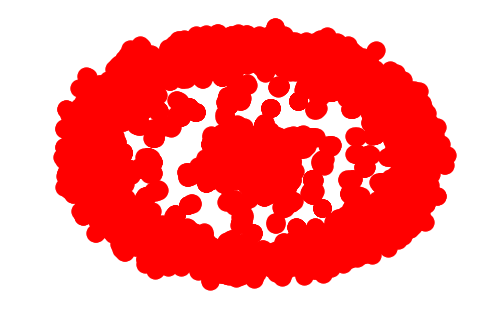

In [64]:
import matplotlib.pyplot as plt

G_Align=nx.Graph()
elist = unique_map
G_Align.add_edges_from(elist)
nx.draw(G_Align)
plt.show()

## compare node and edge connectivity
## compute largest connected component

In [53]:
print('Aligned graph have ',G_Align.number_of_nodes(),' nodes.')
print('Aligned graph have ',G_Align.number_of_edges(),' edges.')

Aligned graph have  7979  nodes.
Aligned graph have  43739  edges.


In [54]:
print('Target graph have ',G_target_na.number_of_nodes(),' nodes.')
print('Target graph have ',G_target_na.number_of_edges(), ' edges.')

Target graph have  7979  nodes.
Target graph have  43795  edges.


In [55]:
sum_weight=0
for i in range(len(unique_xmap)):
    sum_weight=sum_weight+ unique_xmap[i][2]
total_weight=0    
for i in range(len(nd1)):
    for j in range(len(nd2)):
        temp=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
        if(temp!=None):
            total_weight=total_weight+int(list(temp.values())[0])
print('Maximum Weight in Aligned graph: ',sum_weight) 
print('Total Weight in Target: ',total_weight)

Maximum Weight in Aligned graph:  4459554
Total Weight in Target:  4463026


In [56]:
# returns number of different connected components 
print('number of different connected components in Aligned graph: ',nx.number_connected_components(G_Align)) 
print('number of different connected components in Target graph: ',nx.number_connected_components(G_target_na)) 

number of different connected components in Aligned graph:  1086
number of different connected components in Target graph:  1086


In [57]:
# returns list of nodes in different connected components 
cc_align=list(nx.connected_components(G_Align))
cc_target=list(nx.connected_components(G_target_na))
print(list(nx.connected_components(G_Align))) 
print(list(nx.connected_components(G_target_na)))

[{'hs3312', 'hs1804', 'hs8673', 'sc182', 'sc152', 'hs2083', 'hs16366', 'sc545', 'hs7017', 'hs5397', 'hs9911', 'hs3181', 'hs10402', 'hs296', 'hs3646', 'sc406', 'hs4082', 'sc2794', 'sc3626', 'hs11462', 'hs12205', 'sc159', 'hs1305', 'hs16000', 'hs3326', 'hs11647', 'sc3861', 'hs11629', 'sc590', 'sc1234', 'sc3515', 'hs9913', 'sc768', 'hs2150', 'sc4924', 'hs492', 'hs6192', 'sc5088', 'sc1138', 'sc5036', 'hs4548', 'sc3871', 'hs7768', 'hs3943', 'hs5182', 'hs6597', 'hs7440', 'sc3035', 'hs2643', 'hs1065', 'hs6381', 'sc3919', 'hs12825', 'hs94', 'hs4394', 'hs1425', 'hs10592', 'hs9177', 'hs10304', 'hs16769', 'sc761', 'hs2287', 'sc2923', 'hs6170', 'sc4349', 'hs11025', 'hs5053', 'sc2501', 'hs5056', 'sc488', 'hs7283', 'hs12096', 'hs4420', 'hs11856', 'hs485', 'hs3185', 'hs10442', 'hs7518', 'hs326', 'hs11700', 'hs3030', 'hs17689', 'hs14247', 'hs3143', 'sc2464', 'hs673', 'hs6575', 'hs39', 'hs3998', 'hs11322', 'sc2885', 'hs2822', 'sc3544', 'hs4723', 'hs18574', 'sc2961', 'sc1175', 'hs9649', 'hs18070', 'hs90

In [58]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G_Align)) 
print(nx.node_connectivity(G_target_na))
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G_Align))
print(nx.edge_connectivity(G_target_na))

0
0
0
0


# check similarity of connected components

In [59]:
count=0
for i in range(len(cc_align)):
    for j in range(len(cc_target)):
        if(cc_align[i]==cc_target[j]):
            count=count+1
print(count)

1086


In [60]:
Gc = max(nx.connected_component_subgraphs(G_Align), key=len)
print('Largest common connected graph in Aligned graph: ',len(Gc))
Gct = max(nx.connected_component_subgraphs(G_target_na), key=len)
print('Largest common connected graph in Target graph: ',len(Gct))

Largest common connected graph in Aligned graph:  3978
Largest common connected graph in Target graph:  3978


### check for mistake align

In [0]:
for i in range(len(unique_map)):
    if (G_target_na.has_edge(unique_map[i][0], unique_map[i][1])==False):
        print(unique_map[i])
        print(i)
print('no exist error')    

# draw graphs

In [0]:
nx.draw_networkx(G1, with_labels = True)

In [0]:
nx.draw_networkx(G2)

In [0]:
import matplotlib.pyplot as plt
nx.draw(G_target_na)
plt.show()

In [61]:
# total ec
total_ec=G_target_na.number_of_edges()/G1.number_of_edges()*100
ratio_ec=score_ec_temp/total_ec*100
print("total EC: ",total_ec)
print("ratio EC: ",ratio_ec)

total EC:  270.59005251776335
ratio EC:  99.87213152186321


In [62]:
# total ics
total_ics=G_target_na.number_of_edges()/count_induced*100
ratio_ics=score_ics_temp/total_ics*100
print("total ICS: ",total_ics)
print("ratio ICS: ",ratio_ics)

total ICS:  45.459263641931095
ratio ICS:  99.87213152186324


In [63]:
# total s3
total_s3=(G_target_na.number_of_edges()/(G1.number_of_edges()+count_induced-G_target_na.number_of_edges()))*100
ratio_s3=score_s3_temp/total_s3*100
print("total S3: ",total_s3)
print("ratio S3: ",ratio_s3)

total S3:  63.721282137089155
ratio S3:  99.79082252476758


# compute FC

In [1]:
import pickle
with open('sc-hs-weightGraph.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

In [2]:
tree=[[unique_xmap[i][0],unique_xmap[i][1]] for i in range(len(unique_xmap))]
tree

[['sc1134', 'hs6227'],
 ['sc3398', 'hs13895'],
 ['sc1839', 'hs6699'],
 ['sc194', 'hs11970'],
 ['sc1354', 'hs16599'],
 ['sc2271', 'hs993'],
 ['sc1071', 'hs11292'],
 ['sc194', 'hs4937'],
 ['sc2540', 'hs6042'],
 ['sc4383', 'hs5022'],
 ['sc3909', 'hs13817'],
 ['sc3741', 'hs10397'],
 ['sc324', 'hs5924'],
 ['sc2652', 'hs1199'],
 ['sc3136', 'hs2716'],
 ['sc1039', 'hs313'],
 ['sc2206', 'hs11541'],
 ['sc2085', 'hs378'],
 ['sc2833', 'hs9123'],
 ['sc2083', 'hs10472'],
 ['sc3324', 'hs11466'],
 ['sc3850', 'hs11982'],
 ['sc2995', 'hs9789'],
 ['sc2321', 'hs2817'],
 ['sc2321', 'hs7624'],
 ['sc4420', 'hs5394'],
 ['sc3589', 'hs6745'],
 ['sc1333', 'hs11743'],
 ['sc4737', 'hs17084'],
 ['sc841', 'hs2817'],
 ['sc702', 'hs7113'],
 ['sc757', 'hs8787'],
 ['sc48', 'hs902'],
 ['sc1585', 'hs650'],
 ['sc486', 'hs13804'],
 ['sc785', 'hs398'],
 ['sc3922', 'hs10928'],
 ['sc2138', 'hs9618'],
 ['sc2005', 'hs9778'],
 ['sc493', 'hs2072'],
 ['sc3223', 'hs1357'],
 ['sc3173', 'hs5423'],
 ['sc3270', 'hs14070'],
 ['sc393', 'h

# load ontology and create DAG graph

In [3]:
import pandas as pd
f=open('go.dag.obo.txt').readlines()
df=pd.DataFrame(f)
df

,0
0,GO:0046431 GO:0019599\n
1,GO:0046430 GO:0019595\n
2,GO:0046432 GO:0019361\n
3,GO:0034198 GO:0060733\n
4,GO:0046343 GO:0019872\n
5,GO:0034193 GO:0034195\n
6,GO:0034192 GO:0034194\n
7,GO:0034190 GO:0034191\n
8,GO:0046437 GO:0030632 GO:0070179\n
9,GO:0046340 GO:0046342\n


In [4]:
# preprocessing
dag_list=[]
for i in range(len(df[0])):
    m1=str(df[0][i])
    m1=m1.replace('GO:','')
    m1=m1.replace('\n','')
    s=m1.split(' ')
    dag_list.append(s)
dag_list

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658', '0030853', '0045643', '0030854', '0045640'],
 ['0030853', '0045659', '0045644', '0045641'],
 ['0030851', '0030221', '0030223', '0030222'],
 ['0030856',
  '0003339',
  '0030860',
  '0045601',
  '0030857',
  '0072182',
  '0030858',
  '0045616'],
 ['0030857', '0045602', '0030861', '0045617', '0072183'],
 ['0030854', '0045645', '0045642', '0045660'],
 ['0030855',
  '0030859',
  '0030216',
  '0072192',
  '0060671',
  '0072160',
  '0060742',
  '0035026',
  '0072311',
  '0060487',
  '0045446',
  '0060644',
  '0002065'],
 ['0030858', '0045603', '0030862', '0045618'],
 ['0030859', '0045198'],
 ['0031106', '0032186'],
 ['0031105', '0032151', '0032152'],
 ['0031103', '0014814', '0048673', '0014012'],
 ['0031102', '00

In [5]:
dag_nd=[]
for i in range(len(dag_list)):
    for j in range(len(dag_list[i])):
        dag_nd.append(dag_list[i][j])
dag_nodes=set(dag_nd)
print(dag_nodes)
print(len(dag_nodes))

{'0071091', '0000054', '0042597', '0005252', '0001752', '0055023', '0043403', '0052390', '0048446', '0052147', '0043400', '0072124', '0090274', '0004636', '0051682', '0033198', '0047838', '0031587', '0052331', '0031235', '0005225', '0070749', '0032816', '0006284', '0006993', '0006702', '0035377', '0075031', '0043520', '0046687', '0044025', '0075040', '0034341', '0030676', '0052182', '0033120', '0050266', '0031052', '0060015', '0006513', '0042906', '0034146', '0009331', '0000238', '0000329', '0003050', '0050263', '0000474', '0035072', '0005297', '0010551', '0003867', '0009265', '0010855', '0033405', '0031565', '0003068', '0007277', '0019932', '0034913', '0070883', '0033244', '0015255', '0001551', '0033656', '0034413', '0047775', '0016093', '0051768', '0030857', '0051689', '0008520', '0060778', '0033679', '0033715', '0018210', '0080106', '0042575', '0019416', '0060741', '0071418', '0071176', '0070631', '0009664', '0003256', '0051007', '0008314', '0016023', '0019815', '0031044', '0016814'

In [6]:
# create dag edges
dag_edges=[]
for i in range(len(dag_list)):
    for j in range(1,len(dag_list[i])):
        ed=[dag_list[i][0],dag_list[i][j]]
        dag_edges.append(ed)
dag_edges

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632'],
 ['0046437', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658'],
 ['0030852', '0030853'],
 ['0030852', '0045643'],
 ['0030852', '0030854'],
 ['0030852', '0045640'],
 ['0030853', '0045659'],
 ['0030853', '0045644'],
 ['0030853', '0045641'],
 ['0030851', '0030221'],
 ['0030851', '0030223'],
 ['0030851', '0030222'],
 ['0030856', '0003339'],
 ['0030856', '0030860'],
 ['0030856', '0045601'],
 ['0030856', '0030857'],
 ['0030856', '0072182'],
 ['0030856', '0030858'],
 ['0030856', '0045616'],
 ['0030857', '0045602'],
 ['0030857', '0030861'],
 ['0030857', '0045617'],
 ['0030857', '0072183'],
 ['0030854', '0045645'],
 ['0030854', '0045642'],
 ['0030854', '0045660'],
 ['0030855', '0030859'],
 ['0030855', '0030216'],
 ['0030855', '0072192'],
 ['0030855', '0060671'],


In [7]:
import networkx as nx
go=nx.DiGraph()
go.add_nodes_from(dag_nodes)
go.add_edges_from(dag_edges)
go

In [8]:
c=0
import numpy as np
na=tree
for i in range(len(tree)):
    for j in range(2):
        if ('hs' in tree[i][j] or 'sc' in tree[i][j]):
            s=tree[i][j][2:]
            x='0'*(7-len(s))
            y=x+s
            #print(y)
            na[i][j]=y
            c=c+1
print(len(tree),c)
print(len(na))

43734 87468
43734


In [9]:
fc=[]
for i in range(len(na)):
    if na[i][0] in dag_nodes:
        e=go.predecessors(na[i][0])
        if na[i][1] in dag_nodes: 
            f=go.predecessors(na[i][1])
            temp=[]
            for key in e:
                temp.append(key)
            for key in f:
                temp.append(key)
            # compute intersection/union 
            fc.append(sum([temp.count(temp[z])/len(temp) for z in range(len(temp))]))
        else:
            fc.append(0)
#print(fc)
# compute average of all fc 
func=np.average(fc)
print('functional coherence:',func)

functional coherence: 0.6064205171984491
